In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'])

In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_j.shape

(60, 2)

In [5]:
sales_j.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_j['Sales'].sum()

4532957

In [7]:
sales_j = sales_j.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_j.head()

ds      y
0 2019-01-01  63722
1 2019-02-01  76987
2 2019-03-01  99645
3 2019-04-01  68529
4 2019-05-01  45119

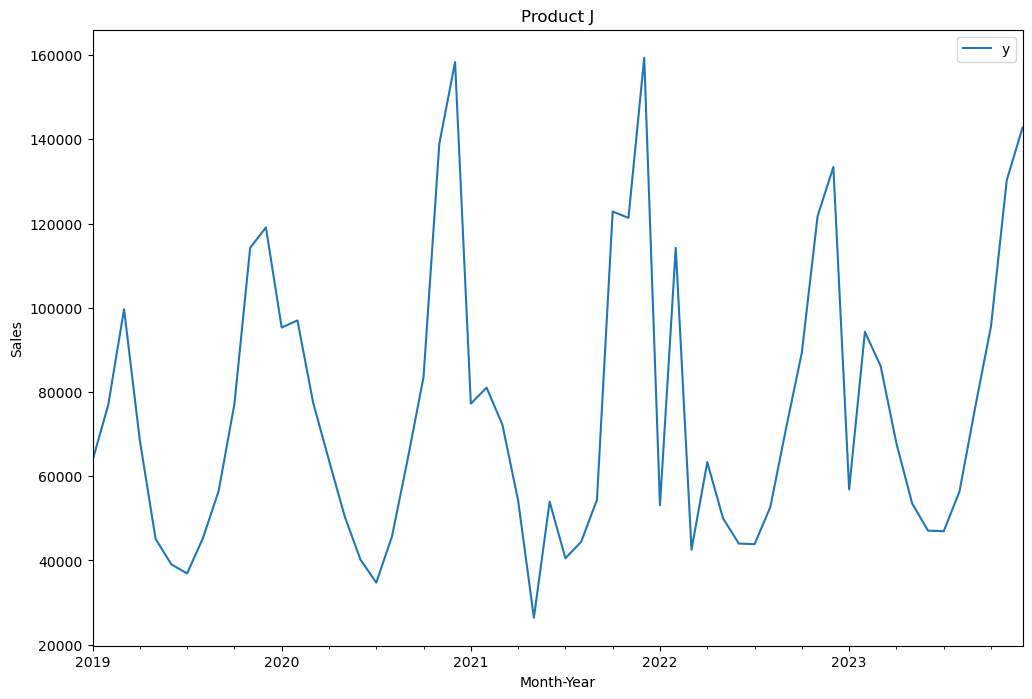

In [8]:
ax = sales_j.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product J')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_j['y'])

ADF Statistics: -2.3759301997991913
p- value: 0.14864548261740318
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_j[:57]
test=sales_j[57:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:02:51 - cmdstanpy - INFO - Chain [1] start processing
16:02:52 - cmdstanpy - INFO - Chain [1] done processing
16:02:58 - cmdstanpy - INFO - Chain [1] start processing
16:02:58 - cmdstanpy - INFO - Chain [1] done processing
16:03:05 - cmdstanpy - INFO - Chain [1] start processing
16:03:05 - cmdstanpy - INFO - Chain [1] done processing
16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing
16:03:18 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing
16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing
16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:42 - cmdstanpy - INFO - Chain [1] done processing
16:03:53 - cmdstanpy - INFO - Chain [1] start processing
16:03:53 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   37036.885444  
1   38676.355358  
2   16698.783781  
3   17395.155827  
4   16974.443220  
..       

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
14                    0.010                     0.10         additive   
26                    0.100                     0.10         additive   
2                     0.001                     0.10         additive   
6                     0.001                     3.00         additive   
18                    0.010                     3.00         additive   
..                      ...                      ...              ...   
13                    0.010                     0.01   multiplicative   
1                     0.001                     0.01   multiplicative   
49                    0.300                     0.01   multiplicative   
60                    0.500                     0.01         additive   
61                    0.500                     0.01   multiplicative   

            rmse  
14  16610.561117  
26  16623.990263  
2   16698.783781  
6   16787.942824  
18  16796.981987  
..           ...  
13  38319.346432  
1   38676.355358  
49  40043.134667  
60  41565.086161  
61  43280.232000  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [16]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.010,seasonality_prior_scale=0.10, seasonality_mode= 'additive',
                interval_width=0.95)

In [17]:
model.fit(train)

16:19:31 - cmdstanpy - INFO - Chain [1] start processing
16:19:31 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
len(test)

3

In [19]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [20]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [21]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [22]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
57 2023-10-01   96420.780623   73156.960797  119941.613292
58 2023-11-01  126499.884048  103880.888885  149902.654827
59 2023-12-01  143245.926871  120994.465030  166534.164463

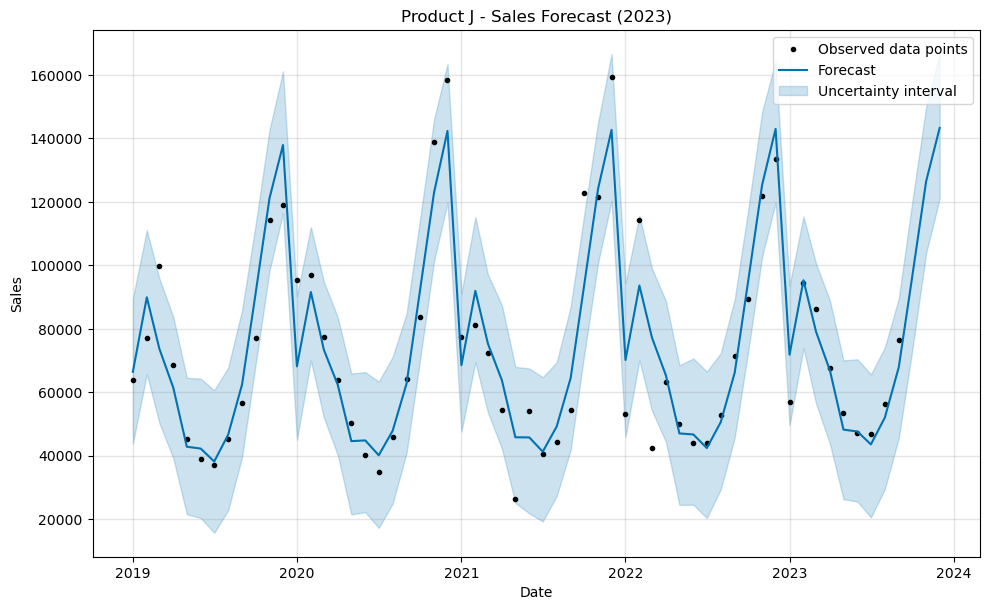

In [23]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product J - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

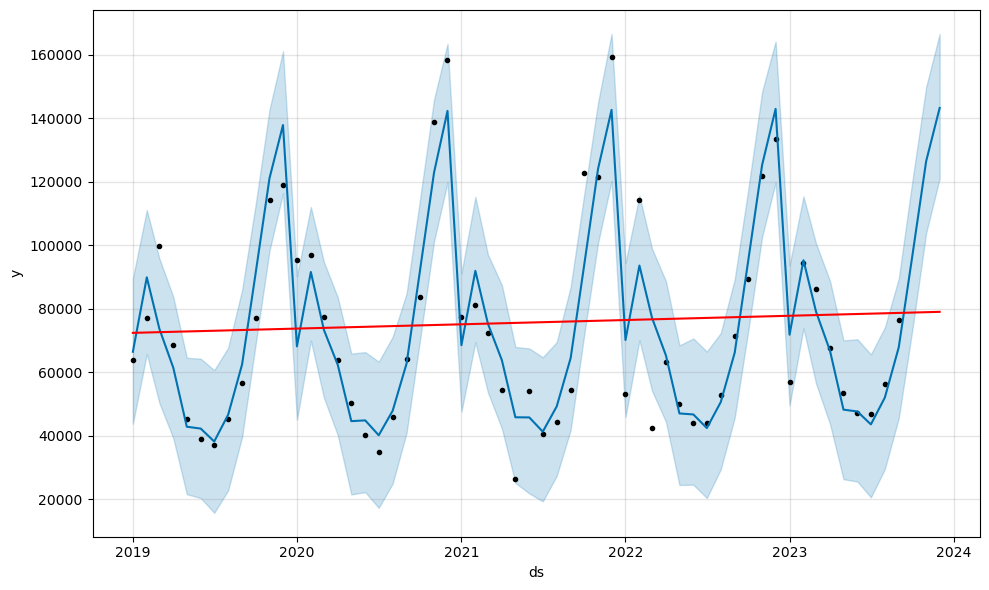

In [24]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

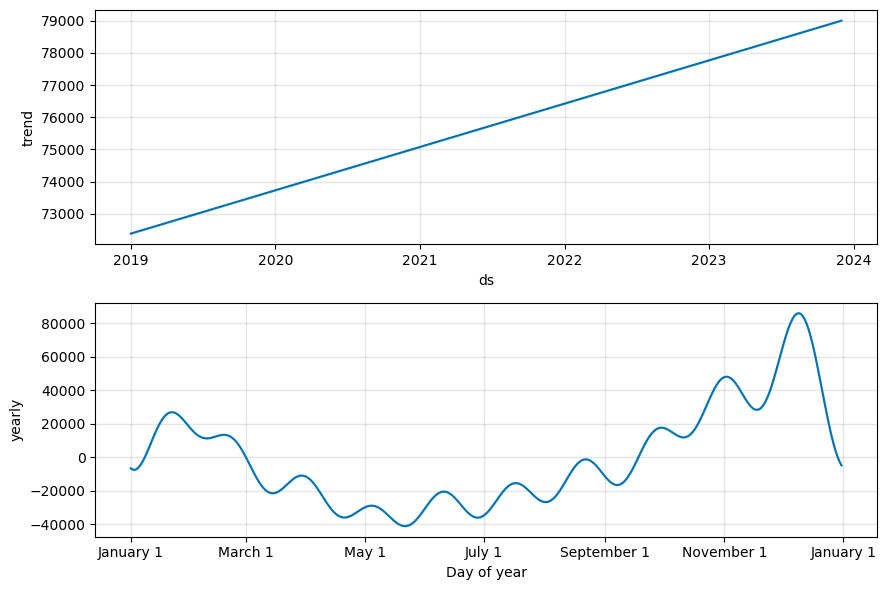

In [25]:
fig2 = model.plot_components(forecast)

In [26]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
57 2023-10-01   96420.780623   73156.960797  119941.613292
58 2023-11-01  126499.884048  103880.888885  149902.654827
59 2023-12-01  143245.926871  120994.465030  166534.164463

In [27]:
sales_j.tail(12) 

ds       y
48 2023-01-01   56843
49 2023-02-01   94268
50 2023-03-01   86135
51 2023-04-01   67767
52 2023-05-01   53500
53 2023-06-01   47080
54 2023-07-01   46924
55 2023-08-01   56348
56 2023-09-01   76393
57 2023-10-01   95597
58 2023-11-01  130293
59 2023-12-01  142757

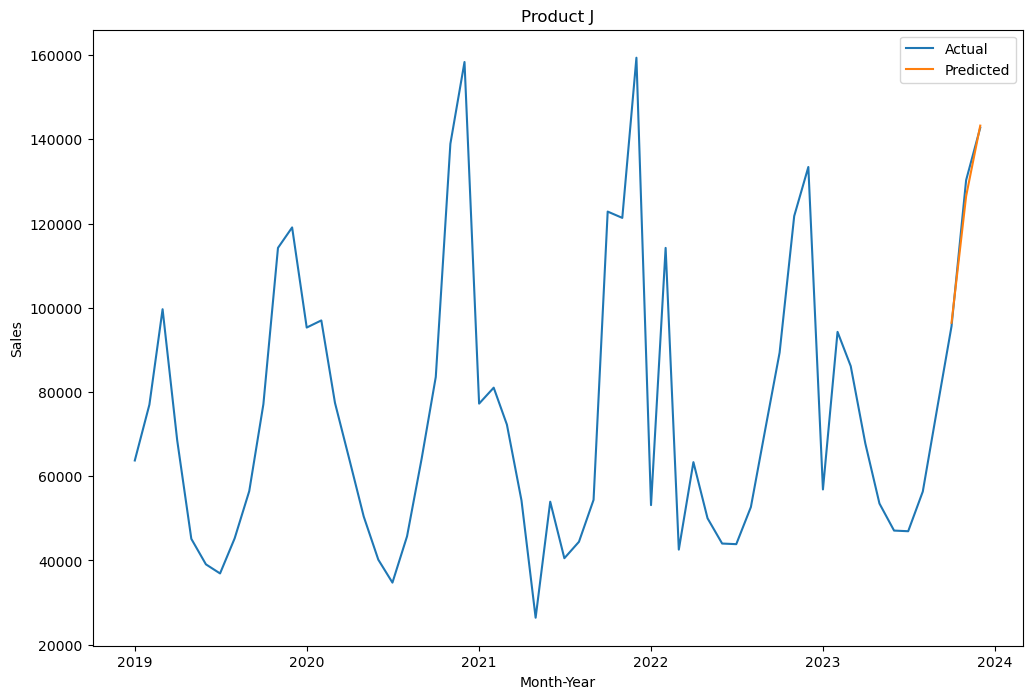

In [28]:
# Reset index of sales_b DataFrame
sales_j_reset_index = sales_j.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_j_reset_index['ds'], sales_j_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product J')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [29]:
#model evaluation

In [30]:
pred=forecasted_df['yhat']
test_df=test['y']

In [31]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 1701.941
MAPE - FB PROPHET: 0.014
MSE - FB PROPHET: 5101797.542
RMSE - FB PROPHET: 2258.716


In [32]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [33]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [34]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0  20 days  6.968498e+08  26397.912241  20660.005091  0.241003  0.312432   
1  22 days  9.098658e+08  30163.982198  24528.915162  0.310127  0.345070   
2  23 days  3.175767e+08  17820.682042  11878.107052  0.228798  0.101084   
3  25 days  1.788220e+08  13372.434084   9041.382036  0.157701  0.101084   
4  27 days  1.152370e+08  10734.847562   9058.965706  0.141220  0.079363   
5  28 days  1.087831e+08  10429.911496   8548.797811  0.154262  0.118490   
6  47 days  3.000243e+08  17321.210594  14154.289664  0.436209  0.118490   
7  49 days  2.533553e+08  15917.137882  11732.153846  0.399664  0.118490   
8  51 days  2.511671e+08  15848.252466  11523.647592  0.373724  0.062513   
9  52 days  2.795235e+07   5286.997819   4969.436629  0.082374  0.062513   
10 53 days  2.212580e+08  14874.742509  12124.185248  0.132287  0.143941   
11 54 days  2.238795e+08  14962.602590  12371.259457  0.154656  0.143941   
12 56 days  2.121717e+08  14566.115714  11333.376354  0.117854  0.107776   
13 57 days  4.094059e+07   6398.483165   6119.195890  0.100676  0.107776   
14 58 days  3.029499e+07   5504.088357   4402.729564  0.066612  0.033534   
15 59 days  4.027279e+07   6346.084236   5317.256004  0.095820  0.121157   
16 78 days  4.235808e+07   6508.308699   5436.053581  0.097586  0.121157   
17 80 days  5.976719e+07   7730.924016   7675.941876  0.140148  0.133267   
18 81 days  8.882553e+08  29803.612260  24944.781043  0.453326  0.133267   
19 83 days  8.727125e+08  29541.707212  23337.454449  0.427267  0.131672   
20 85 days  4.814455e+08  21941.865820  15907.218451  0.276523  0.161122   
21 86 days  1.311482e+08  11451.995564  11439.771951  0.125471  0.124948   
22 88 days  8.744119e+07   9350.999245   7971.763329  0.079548  0.090344   
23 90 days  9.368908e+07   9679.312157   8242.083105  0.096982  0.124948   

       smape  coverage  
0   0.251655  0.333333  
1   0.291313  0.333333  
2   0.187794  0.666667  
3   0.137086  0.833333  
4   0.127781  1.000000  
5   0.144321  1.000000  
6   0.318024  0.666667  
7   0.287062  0.666667  
8   0.258363  0.666667  
9   0.085193  1.000000  
10  0.144137  0.666667  
11  0.168823  0.666667  
12  0.128116  0.666667  
13  0.107220  1.000000  
14  0.071114  1.000000  
15  0.103111  1.000000  
16  0.105205  1.000000  
17  0.144986  1.000000  
18  0.324501  0.333333  
19  0.300725  0.333333  
20  0.217711  0.666667  
21  0.131651  1.000000  
22  0.081114  1.000000  
23  0.102446  1.000000

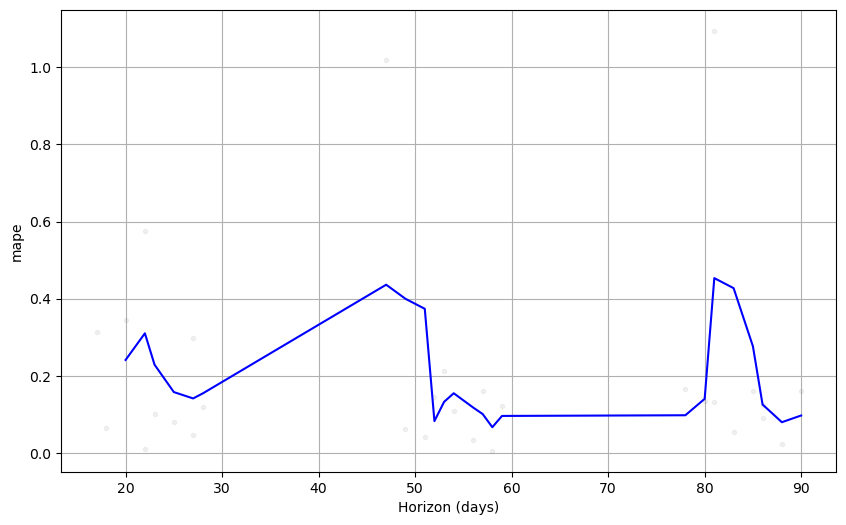

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [36]:
test_df

57     95597
58    130293
59    142757
Name: y, dtype: int64

In [37]:
pred

57     96420.780623
58    126499.884048
59    143245.926871
Name: yhat, dtype: float64

# FORECASTING

In [38]:
model_forecast = Prophet( changepoint_prior_scale= 0.010,seasonality_prior_scale=0.10, seasonality_mode= 'additive',
                interval_width=0.95)

In [39]:
model_forecast.fit(sales_j)

16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [41]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [42]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [43]:
forecasted_f_df

ds          yhat    yhat_lower     yhat_upper
60 2024-01-01  73243.874708  49935.499696   95293.650195
61 2024-02-01  96705.017055  74722.028254  116754.323396
62 2024-03-01  78467.641125  55648.298071  100325.488490

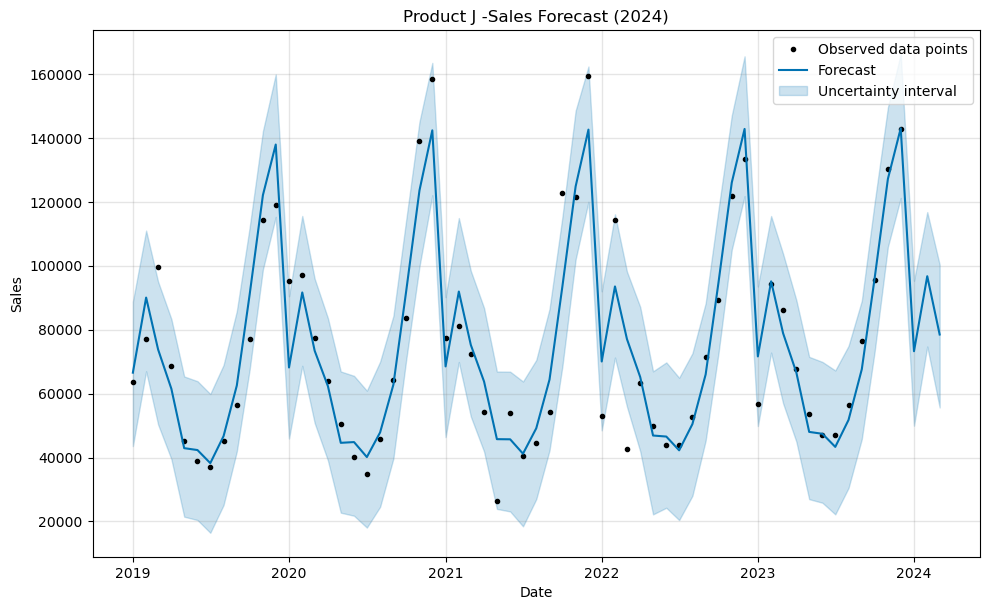

In [44]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product J -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [45]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [46]:
plot_components_plotly(model_forecast, forecast_f)